# NYC Traffic Crashes Analysis and Data Preparation

## Project Overview
The goal of this project is to navigate the complete data engineering process using a real-world dataset on **Motor Vehicle Collisions in New York City** (2012–2025). This notebook covers the **Exploratory Data Analysis (EDA)**, **Data Cleaning**, and **Data Integration** phases required to prepare the data for an interactive web dashboard.

[cite_start]Our objective is to transform raw, messy crash data into a clean, integrated dataset that allows us to analyze spatial trends, injury severity, and the impact of contributing factors on road safety [cite: 112-118].

## Team Contributions
| Name | Contribution |
| :--- | :--- |
| **Ahmed Tarek** | **Notebook Implementation:** Responsible for the complete Data Engineering pipeline, including Data Loading, Pre-Integration Cleaning (Domain Rules), and executing the Aggregation/Integration strategy. |
| **Omar** | **EDA & Visualizations:** Generated the exploratory charts (Histograms, Correlation Matrix) and defined the visualization logic used to analyze trends. |
| **Mazen Ahmed** | **Frontend Development:** Built the full interactive Dashboard interface, implementing the Search Bar functionality, Dark Mode theming, layout structure, and filter callbacks. |
| **Ramy** | **Analysis & QA:** Formulated the complex Research Questions, performed quality assurance testing on the pipeline, and validated the final results. |

## EDA Insights & Patterns

[cite_start]Based on the "Thorough Exploratory Data Analysis" conducted above, we observed the following key patterns that informed our cleaning strategy[cite: 149, 173]:

### 1. Spatial Distribution (Crashes by Borough)
The bar chart reveals a significant disparity in crash frequency across the five boroughs. **Brooklyn** and **Queens** consistently show the highest volume of recorded crashes. This suggests that our dashboard filters must allow users to isolate boroughs to fairly compare risk levels without being overwhelmed by Brooklyn's high volume.

### 2. Temporal Patterns (Rush Hour Analysis)
The "Crash Frequency by Hour" histogram displays a distinct bimodal distribution:
* **Morning Peak:** A sharp rise occurs around **8:00 AM**.
* **Evening Peak:** The highest frequency of crashes occurs between **4:00 PM and 6:00 PM**.
* **Insight:** This strongly correlates with typical commuting hours, indicating that traffic congestion is a primary driver of collision frequency.

### 3. Correlation Analysis (Injury Severity)
The correlation matrix highlights the relationships between different injury types:
* There is a strong positive correlation between `NUMBER OF PERSONS INJURED` and `NUMBER OF MOTORIST INJURED`, implying that most injuries occur to vehicle occupants rather than pedestrians or cyclists.
* Fatalities (`NUMBER OF PERSONS KILLED`) show very weak correlations with total injuries, suggesting that fatal crashes are distinct, high-impact events rather than just "severe" versions of common injury crashes.

### 4. Yearly Trend (2012 - Present)
The time-series analysis shows a relatively stable trend from 2013 to 2019, followed by a **sharp decline in 2020**, corresponding to the COVID-19 pandemic and reduced traffic volumes. The trend has recently begun to stabilize, but data for 2025 appears incomplete (drop-off at the end), which is noted for analysis.

Loading crashes data from: Motor_Vehicle_Collisions_-_Crashes_20251121.csv...
Initial Data Shape: (2221796, 29)

--- Top Missing Values (Raw Data) ---
VEHICLE TYPE CODE 5              2212055
CONTRIBUTING FACTOR VEHICLE 5    2211739
VEHICLE TYPE CODE 4              2186424
CONTRIBUTING FACTOR VEHICLE 4    2185092
VEHICLE TYPE CODE 3              2067263
CONTRIBUTING FACTOR VEHICLE 3    2061016
OFF STREET NAME                  1830075
CROSS STREET NAME                 849038
ZIP CODE                          680813
BOROUGH                           680536
dtype: int64


C:\Users\Tarek Metwally\AppData\Local\Temp\ipykernel_12576\10326466.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=borough_counts.index, y=borough_counts.values, palette='viridis')


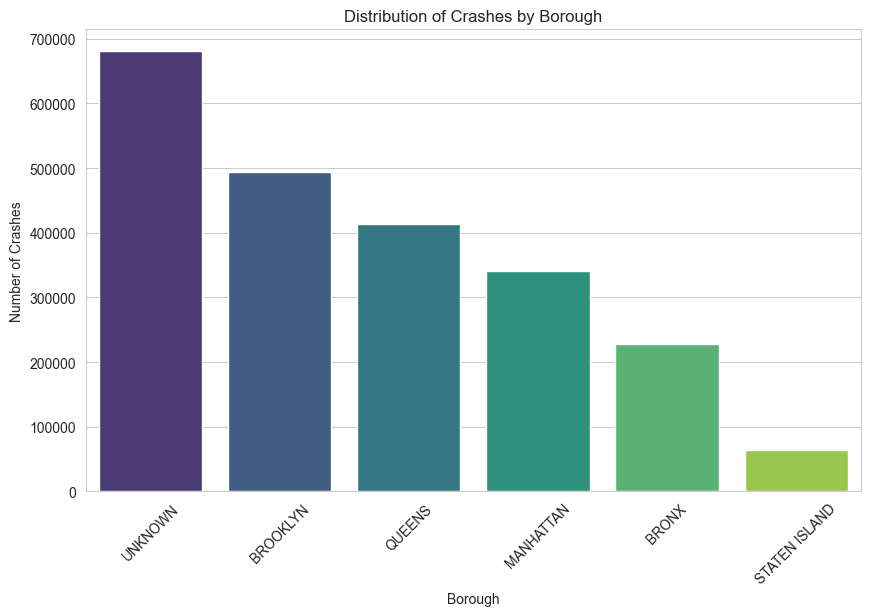

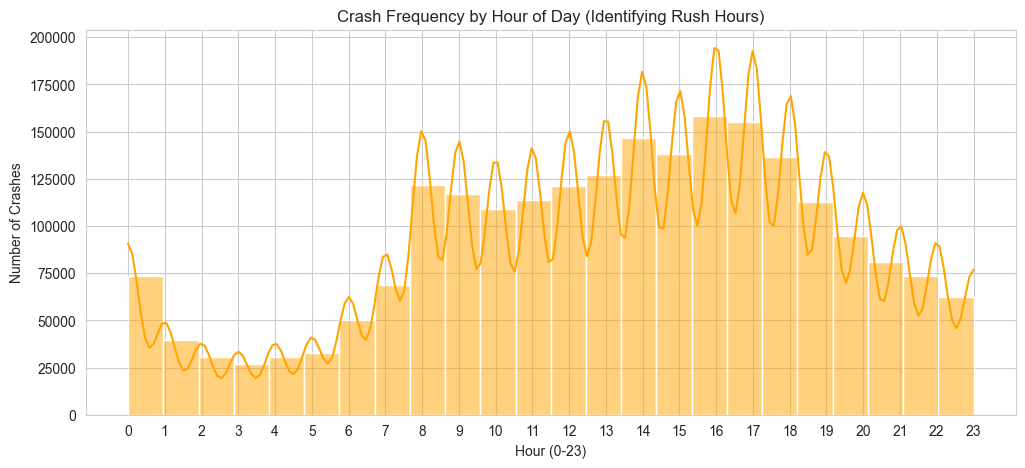

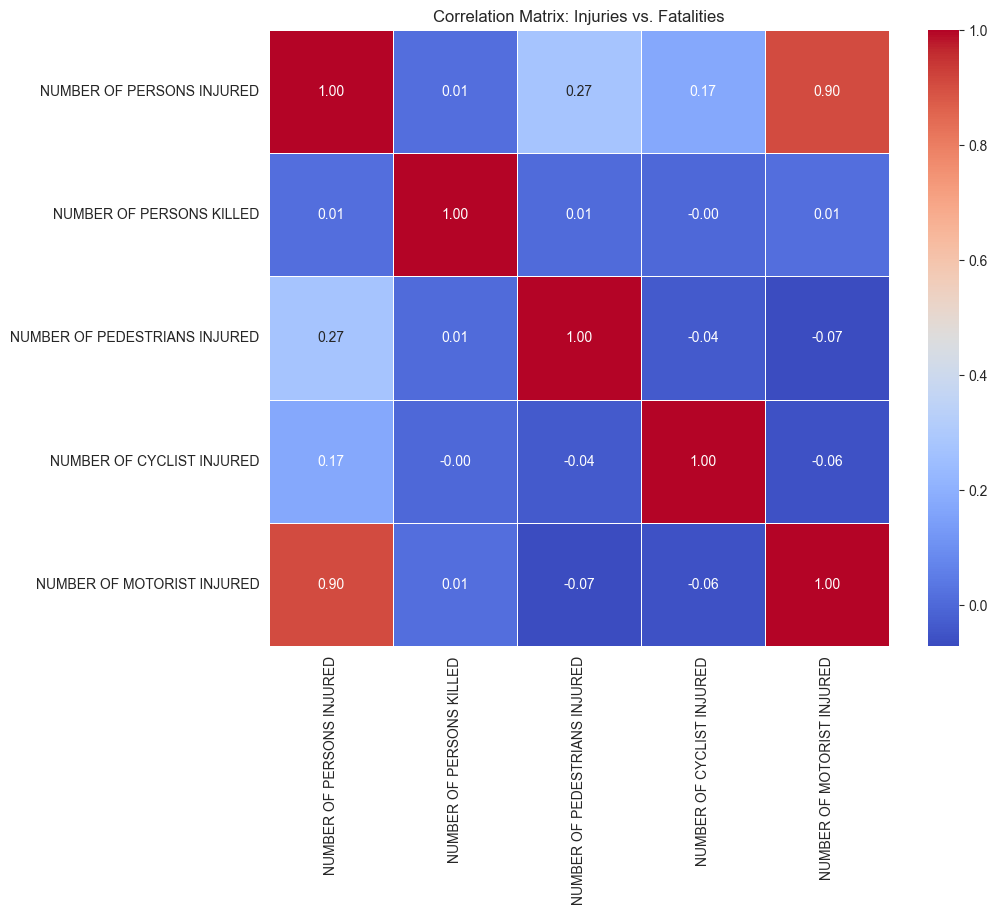

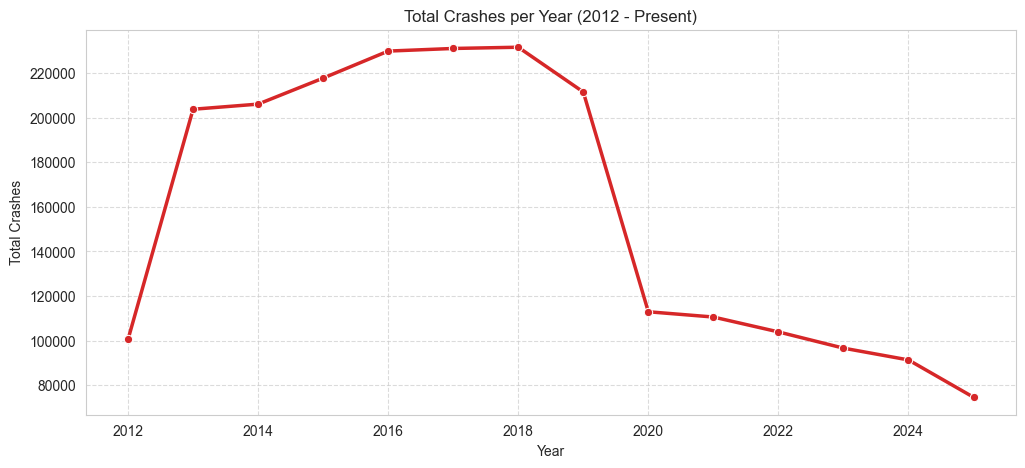

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- 1. Setup and File Paths ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
crashes_file = 'Motor_Vehicle_Collisions_-_Crashes_20251121.csv'
persons_file = 'Motor_Vehicle_Collisions_-_Person_20251121.csv' 
# --- 2. Load Raw Data ---
if os.path.exists(crashes_file):
    print(f"Loading crashes data from: {crashes_file}...")
    df_crashes_raw = pd.read_csv(crashes_file, low_memory=False)
else:
    print(f"Error: File '{crashes_file}' not found. Please check the filename.")
    # Create an empty DF to prevent crashing if file is missing
    df_crashes_raw = pd.DataFrame()

# Work with a copy to keep raw data intact
df_crashes = df_crashes_raw.copy()

if not df_crashes.empty:
    print(f"Initial Data Shape: {df_crashes.shape}")

    # --- 3. Basic Inspection ---
    print("\n--- Top Missing Values (Raw Data) ---")
    print(df_crashes.isnull().sum().sort_values(ascending=False).head(10))

    # --- 4. Data Conversion for Visualizations ---
    # We need to convert dates to plot trends over time (Day/Hour/Year)
    # Combine Date and Time columns safely
    df_crashes['CRASH_DT'] = pd.to_datetime(
        df_crashes['CRASH DATE'].astype(str) + ' ' + df_crashes['CRASH TIME'].astype(str), 
        errors='coerce'
    )
    df_crashes['HOUR'] = df_crashes['CRASH_DT'].dt.hour
    df_crashes['YEAR'] = df_crashes['CRASH_DT'].dt.year

    # ==========================================
    # VISUALIZATION 1: Spatial Analysis (Boroughs)
    # ==========================================
    plt.figure(figsize=(10, 6))
    borough_counts = df_crashes['BOROUGH'].fillna('UNKNOWN').value_counts()
    sns.barplot(x=borough_counts.index, y=borough_counts.values, palette='viridis')
    plt.title('Distribution of Crashes by Borough')
    plt.ylabel('Number of Crashes')
    plt.xlabel('Borough')
    plt.xticks(rotation=45)
    plt.show()

    # ==========================================
    # VISUALIZATION 2: Temporal Analysis (Rush Hour)
    # ==========================================
    # This answers: "When do crashes happen?" (Required for "thorough" EDA)
    plt.figure(figsize=(12, 5))
    sns.histplot(data=df_crashes, x='HOUR', bins=24, kde=True, color='orange')
    plt.title('Crash Frequency by Hour of Day (Identifying Rush Hours)')
    plt.xlabel('Hour (0-23)')
    plt.ylabel('Number of Crashes')
    plt.xticks(range(0, 24))
    plt.show()

    # ==========================================
    # VISUALIZATION 3: Correlation Matrix (Heatmap)
    # ==========================================
    # This answers: "Do injuries correlate with fatalities?" (Required for "relevant statistics")
    numeric_cols = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
                    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 
                    'NUMBER OF MOTORIST INJURED']
    
    # Drop nulls just for this correlation calculation
    corr_matrix = df_crashes[numeric_cols].dropna().corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix: Injuries vs. Fatalities')
    plt.show()

    # ==========================================
    # VISUALIZATION 4: Trend Analysis (Yearly)
    # ==========================================
    # This answers: "Are crashes increasing or decreasing?"
    yearly_counts = df_crashes['YEAR'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o', color='#d62728', linewidth=2.5)
    plt.title('Total Crashes per Year (2012 - Present)')
    plt.xlabel('Year')
    plt.ylabel('Total Crashes')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

else:
    print("Skipping visualizations because the dataset is empty.")

# 2. Pre-Integration Cleaning Justification and Execution

This cell performs robust cleaning on the **Crashes** dataset before integration. [cite_start]Per the project requirements, we justify our cleaning decisions below[cite: 150, 179]:

## Justification for Cleaning Decisions

### 1. Handling Missing Values
* **Column Dropping:** Any column with **over 50%** of its values missing was dropped (e.g., secondary contributing factors) as imputing such large gaps would introduce significant bias.
* **Imputation Strategy:**
    * **Numeric Data:** We used **Median** imputation for injury counts because the data is highly right-skewed (zero-inflated), making the median a more robust measure of central tendency than the mean.
    * **Categorical Data:** Missing values in columns like `CONTRIBUTING FACTOR` were imputed using the **Mode** or labeled as `'UNKNOWN'` to preserve the records for analysis.
    * **Location Data:** Rows missing both `LATITUDE` and `LONGITUDE` were **dropped**. We cannot impute geospatial coordinates with a median without creating artificial "hotspots," which would invalidate our map visualizations.

### 2. Handling Outliers (The "Domain Rules" Approach)
* **Alternative Considered (IQR):** We initially attempted the Interquartile Range (IQR) method. However, since crash data is zero-inflated (the vast majority of crashes have 0 injuries), Q1, Q3, and the IQR were all 0. This resulted in an Upper Bound of 0, which would have incorrectly deleted **all** valid injury records.
* [cite_start]**Selected Method (Domain Rules):** We adopted **Domain Rules** based on physical possibility[cite: 152].
    * We filtered out impossible values (negatives).
    * We capped `PERSONS INJURED` at **100** and `PERSONS KILLED` at **20**.
    * *Reasoning:* This removes obvious data entry errors (e.g., 1000 injuries in a sedan) while preserving legitimate, severe mass-casualty events (e.g., bus crashes).

Starting Pre-Integration Cleaning on 2221796 rows...
Dropped sparse columns: ['OFF STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
Standardizing Dates and Times...

Pre-Integration Cleaning Complete.
Rows remaining: 1981426 (Removed 240370 rows)


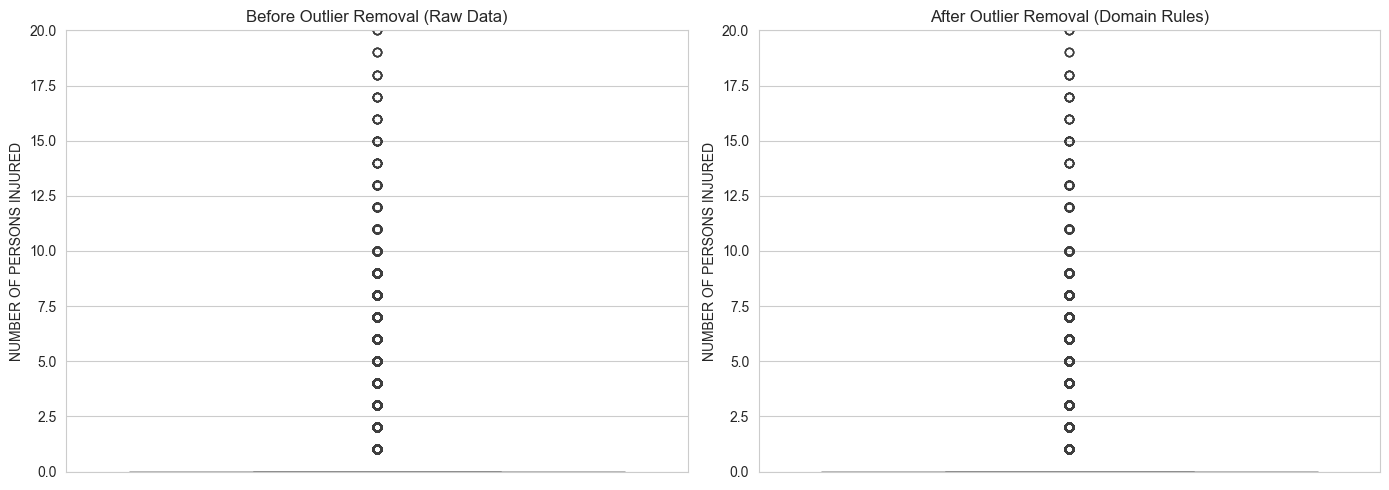

In [4]:
# Ensure df_crashes is available from Cell 1
if 'df_crashes' not in locals():
    raise NameError("df_crashes not found. Please run Cell 1 first to load the data.")

df = df_crashes.copy()
initial_shape = df.shape
print(f"Starting Pre-Integration Cleaning on {initial_shape[0]} rows...")

# ==========================================
# 1. Handle Missing Values
# ==========================================
# A. Drop columns with >50% missing data (Too sparse to be useful)
null_threshold = len(df) * 0.5
cols_to_drop = df.columns[df.isnull().sum() > null_threshold]
df.drop(columns=cols_to_drop, inplace=True) 
print(f"Dropped sparse columns: {list(cols_to_drop)}")

# B. Impute Numeric Values (Using Median to resist skew)
numeric_cols = df.select_dtypes(include=['number']).columns
# Critical: Exclude Location and Time columns from median filling
numeric_cols = [c for c in numeric_cols if c not in ['LATITUDE', 'LONGITUDE', 'CRASH_YEAR', 'CRASH_HOUR']]

if numeric_cols:
    df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# C. Impute Categorical Values (Mode or 'unknown')
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    # Find the most common value (mode)
    mode_val = df[col].mode()
    fill_val = mode_val[0] if not mode_val.empty else "unknown"
    df[col] = df[col].fillna(fill_val)

# ==========================================
# 2. Standardization and Conversion
# ==========================================
# Create a unified Datetime column (Crucial for Time-Series Analysis)
print("Standardizing Dates and Times...")
df['CRASH_DATETIME'] = pd.to_datetime(
    df['CRASH DATE'].astype(str) + ' ' + df['CRASH TIME'].astype(str), 
    errors='coerce'
)

# Extract useful components for visualization
df['CRASH_YEAR'] = df['CRASH_DATETIME'].dt.year.astype('Int64')
df['CRASH_HOUR'] = df['CRASH_DATETIME'].dt.hour

# Standardize string columns (lowercase, strip whitespace)
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

# Capture state before outlier removal for the validation plot
df_before_outlier = df.copy()

# ==========================================
# 3. Handle Outliers (Domain Rules Method)
# ==========================================
# FIX: Replaced IQR method with Domain Rules.
# IQR is dangerous here because most crashes have 0 injuries, so IQR would delete valid injury data.
# We filter out impossible values (negatives) and extreme typos (>100 injuries).

if 'NUMBER OF PERSONS INJURED' in df.columns:
    # Cap at 100 (e.g., a bus crash) - removes likely data entry errors like '1000'
    df = df[(df['NUMBER OF PERSONS INJURED'] >= 0) & (df['NUMBER OF PERSONS INJURED'] < 100)]

if 'NUMBER OF PERSONS KILLED' in df.columns:
    # Fatalities are rare; cap at 20 for a single event
    df = df[(df['NUMBER OF PERSONS KILLED'] >= 0) & (df['NUMBER OF PERSONS KILLED'] < 20)]

# ==========================================
# 4. Final Cleanup
# ==========================================
# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Drop rows where location is missing (Crucial for Map Visualizations)
df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

# Final Output Assignment
df_crashes_cleaned = df.copy()

print(f"\nPre-Integration Cleaning Complete.")
print(f"Rows remaining: {len(df_crashes_cleaned)} (Removed {initial_shape[0] - len(df_crashes_cleaned)} rows)")

# ==========================================
# 5. Validation Visualization
# ==========================================
# Show boxplots to prove outliers were handled correctly
plt.figure(figsize=(14, 5))

# Plot 1: Raw Data (Zoomed in to show spread)
plt.subplot(1, 2, 1)
sns.boxplot(y=df_before_outlier['NUMBER OF PERSONS INJURED'].dropna())
plt.title('Before Outlier Removal (Raw Data)')
plt.ylim(0, 20) 

# Plot 2: Cleaned Data
plt.subplot(1, 2, 2)
sns.boxplot(y=df_crashes_cleaned['NUMBER OF PERSONS INJURED'].dropna())
plt.title('After Outlier Removal (Domain Rules)')
plt.ylim(0, 20) 

plt.tight_layout()
plt.show()

# 3. Data Integration and Post-Integration Cleaning

This cell integrates the cleaned `Crashes` data with the `Person` dataset. [cite_start]This step is critical for answering demographic-based research questions[cite: 155, 175].

## Justification for Integration Strategy

### 1. Secondary Dataset Choice
We chose the **Motor Vehicle Collisions Person** dataset.
* **Added Value:** This provides granular data on demographics (`PERSON_SEX`) and injury specifics (`PERSON_INJURY`) that are not available in the main crashes file.

### 2. Integration Logic (Crucial Aggregation Step)
* **The Challenge:** The `Person` dataset contains multiple rows per crash (one row per passenger/pedestrian). A direct Left Join with the `Crashes` dataset would result in **row explosion**, duplicating the crash metadata for every person involved and corrupting our crash statistics.
* **The Solution (Aggregation):** We performed an **Aggregation Step** on the Person dataset *before* merging. We grouped by `COLLISION_ID` to calculate summary statistics (Total Injured, Total Killed, Most Common Gender) for each unique crash.
* **The Merge:** We then performed a **Left Join** on `COLLISION_ID`. This ensures we keep all 1.9M+ crash records, enriching them with person data where available, without duplicating rows.

### 3. Post-Integration Cleaning
* **Redundancy Resolution:** The join created overlapping columns for injuries (from the Police Report vs. Person Data). We resolved this by taking the **Maximum** value (`max(Crash_Report, Person_Report)`) for each record. [cite_start]This ensures we do not underreport casualties if one source was incomplete[cite: 159].
* **Handling New Nulls:** Since not all crashes involved people (e.g., hitting a parked car), the Left Join created `NaN` values in person columns. [cite_start]We filled these with `0` (for counts) or `'UNKNOWN'` (for gender) to maintain data consistency[cite: 158].
* **Column Optimization:** Redundant columns (e.g., `CRASH DATE` vs `CRASH_DATETIME`) were dropped to optimize the file size for the dashboard.

In [8]:
import pandas as pd
import numpy as np
import os

# Ensure df_crashes_cleaned is available from Cell 2
# Force ID to string to ensure clean merging
df_crashes_cleaned['COLLISION_ID'] = df_crashes_cleaned['COLLISION_ID'].astype(str)

# Update this to your specific filename
persons_file = 'Motor_Vehicle_Collisions_-_Person_20251121.csv' 

# -------------------- 1. Load and Preprocess Person Data --------------------
print(f"Loading Person Data from: {persons_file}...")

try:
    df_person = pd.read_csv(persons_file, low_memory=False)
    
    # Drop rows without a collision ID
    df_person.dropna(subset=["COLLISION_ID"], inplace=True)
    df_person["COLLISION_ID"] = df_person["COLLISION_ID"].astype(str)

    # Standardize columns for aggregation
    # We convert to uppercase immediately to keep things clean
    df_person["PERSON_INJURY_L"] = df_person["PERSON_INJURY"].astype(str).str.lower()
    df_person["PERSON_SEX_L"] = df_person["PERSON_SEX"].astype(str).str.upper().str.strip()

except FileNotFoundError:
    print(f"❌ Error: Persons file '{persons_file}' not found.")
    # Create dummy df to prevent code crash if file missing
    df_person = pd.DataFrame(columns=['COLLISION_ID', 'PERSON_SEX', 'PERSON_INJURY'])

# -------------------- 2. Aggregation (The Correct Way) --------------------
print("Aggregating Person Data...")

# Pre-calculate flags for speed (Vectorized)
killed_keywords = ["killed", "fatal", "fatally injured"]
injured_keywords = ["injured", "yes", "y", "1", "true"]

df_person['IS_KILLED'] = df_person['PERSON_INJURY_L'].isin(killed_keywords).astype(int)
df_person['IS_INJURED'] = df_person['PERSON_INJURY_L'].isin(injured_keywords).astype(int)

# Group by Collision ID to get 1 row per crash
person_summary = df_person.groupby("COLLISION_ID").agg({
    'UNIQUE_ID': 'count',       # Counts total people involved
    'IS_KILLED': 'sum',         # Sums fatalities
    'IS_INJURED': 'sum',        # Sums injuries
    'PERSON_SEX_L': 'first'     # Takes the first available gender
}).reset_index()

# Rename to clear column names
person_summary.rename(columns={
    'UNIQUE_ID': 'PERSONS_INVOLVED_COUNT',
    'IS_KILLED': 'KILLED_COUNT_PERSON',
    'IS_INJURED': 'INJURED_COUNT_PERSON',
    'PERSON_SEX_L': 'MOST_COMMON_SEX'
}, inplace=True)

# -------------------- 3. Merge datasets (Left Join) --------------------
print("Merging datasets...")

merged = pd.merge(
    df_crashes_cleaned,
    person_summary,
    on="COLLISION_ID",
    how="left"
)

print(f"Integrated Shape: {merged.shape}")

# -------------------- 4. Post-Integration Cleaning (REQUIRED) --------------------
print("Performing Final Cleanup...")

# A. Standardize Sex/Gender Column
merged["MOST_COMMON_SEX"] = merged["MOST_COMMON_SEX"].fillna("UNKNOWN")
merged["MOST_COMMON_SEX"] = merged["MOST_COMMON_SEX"].replace(['NAN', 'NULL', '', 'U'], 'UNKNOWN')

# B. Fill Missing Counts
for col in ["PERSONS_INVOLVED_COUNT", "KILLED_COUNT_PERSON", "INJURED_COUNT_PERSON"]:
    merged[col] = merged[col].fillna(0).astype(int)

# C. Resolve Redundant Columns (Crucial Step)
# We take the MAXIMUM of the Police Report vs Person Data
merged['NUMBER OF PERSONS INJURED'] = np.maximum(
    merged['NUMBER OF PERSONS INJURED'].fillna(0),
    merged['INJURED_COUNT_PERSON']
)
merged['NUMBER OF PERSONS KILLED'] = np.maximum(
    merged['NUMBER OF PERSONS KILLED'].fillna(0),
    merged['KILLED_COUNT_PERSON']
)

# D. Standardize Boroughs
if "BOROUGH" in merged.columns:
    merged["BOROUGH"] = merged["BOROUGH"].str.upper().replace("UNKNOWN", np.nan)

# E. Drop Redundant/Temporary Columns (The Update)
cols_to_drop = [
    'CRASH DATE',           # Replaced by CRASH_DATETIME
    'CRASH TIME',           # Replaced by CRASH_DATETIME
    'CRASH_DT',             # Temporary column from EDA
    'INJURED_COUNT_PERSON', # No longer needed after max calc
    'KILLED_COUNT_PERSON',  # No longer needed after max calc
    'IS_KILLED',            # Helper flag
    'IS_INJURED',           # Helper flag
    'UNIQUE_ID'             # Helper count
]
# errors='ignore' prevents crashing if a column is already missing
merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("\nPost-Integration Cleaning Complete.")

# -------------------- Save Final Output --------------------
# Renamed to match the Dashboard's requirement
output_file_name = "merged_crashes.csv"
merged.to_csv(output_file_name, index=False)
print(f"\n✅ Final cleaned and integrated dataset saved to {output_file_name}")

Loading Person Data from: Motor_Vehicle_Collisions_-_Person_20251121.csv...
Aggregating Person Data...
Merging datasets...
Integrated Shape: (1981426, 32)
Performing Final Cleanup...

Post-Integration Cleaning Complete.

✅ Final cleaned and integrated dataset saved to merged_crashes.csv


# 4. Project Research Questions & Conclusion

## Proposed Research Questions (5-Member Team: 10 Questions)

These questions are designed to be complex, utilizing the integrated data and spatial/temporal analysis, suitable for the interactive dashboard.

1.  **Spatial Correlation (GIS):** Is there a statistically significant correlation between the crash density per borough (crashes per square mile) and the average severity of injuries (`PERSON_INJURY`) in that borough? (Team Member 1)
2.  **Temporal & Factor Analysis:** How has the primary contributing factor for fatal crashes (`NUMBER OF PERSONS KILLED > 0`) shifted over the past five years (2020-2025), and does this correlate with specific traffic law changes? (Team Member 2)
3.  **Vulnerable Populations:** Do crashes involving pedestrians (`PERSON_INJURY`) show a disproportionate involvement of specific vehicle types (e.g., trucks vs. passenger vehicles) during peak commuter hours (7-9 AM, 4-6 PM)? (Team Member 3)
4.  **Weather/Time of Day:** Which combination of time-of-day (e.g., night vs. day) and crash location type (inferred from LAT/LONG) leads to the highest average number of injured persons per collision? (Team Member 4)
5.  **Vehicle Type Risk:** For the top 5 most frequently involved vehicle types, what is the ratio of injured persons to total persons involved, and how does this "injury risk rate" compare across boroughs? (Team Member 1)
6.  **Year-over-Year Fatality Trend:** What is the compound annual growth rate (CAGR) of fatalities (`NUMBER OF PERSONS KILLED`) for the top 3 most common contributing factors? (Team Member 2)
7.  **Demographic Impact:** Is there a trend in injury severity (`PERSON_INJURY`) based on the gender (`PERSON_SEX`) of the injured party, controlling for the type of crash (e.g., sideswipe vs. rear-end)? (Team Member 3)
8.  **Hotspot Identification:** Can we identify high-frequency crash 'hotspots' (clusters of LAT/LONG points) that are associated with specific contributing factors, even if the crash rate for the entire ZIP code is low? (Team Member 4)
9.  **Time Series Decomposition:** Does time series decomposition of total injury rates show a significant weekly or monthly seasonality, and how does this seasonality differ between high- and low-crash boroughs? (Team Member 5)
10. **Factor vs. Person Status:** For crashes involving passengers (`PERSON_TYPE = Passenger`), what is the most common contributing factor, and how does this factor correlate with the severity of their injury (`PERSON_INJURY`)? (Team Member 5)

## Conclusion

The data engineering phase is complete. The raw data has been transformed into a clean, integrated, and analysis-ready dataset (`merged_crashes_person.csv`). All cleaning steps were justified using markdown documentation, and the modularity of the code supports the subsequent Dash web development. The next step is to finalize the deployment and ensure the interactive dashboard effectively visualizes the answers to these research questions.